# N armed bandits

En este capítulo vemos el problema de N armed bandits (N máquinas tragamonedas) que es un problema clásico de aprendizaje por refuerzo.

En este problema, un agente se enfrenta a N máquinas tragamonedas, cada una con una recompensa diferente.

El agente no sabe cuál es la recompensa de cada máquina y debe aprender a elegir la máquina que le dará la mayor recompensa.

Este problema nos servirá como excusa para introducir conceptos básicos de aprendizaje por refuerzo como los rewards del entorno, el algoritmo de actualización de valor Q (valor de acción) y el algoritmo de selección de acción epsilon-greedy.

## Definición del problema

El problema de N armed bandits se define de la siguiente manera:

1. El agente se enfrenta a N máquinas tragamonedas (bandits).
2. Cada máquina tragamonedas tiene una recompensa (reward) media diferente.
3. El agente no sabe cuál es la recompensa media de cada máquina.
4. El agente debe aprender a elegir la máquina que le dará la mayor recompensa experimentando con las máquinas y observando las recompensas que obtiene.

## Cálculo del valor de cada acción

Cada acción (elegir una máquina) tiene asociado un valor que es la recompensa media que se obtiene al elegir esa máquina.

El valor de una acción se denota como $q(a)$ donde a es la acción (elegir una máquina).

Al principio, el agente no sabe cuál es el valor de cada acción y debe aprenderlo a través de la experiencia, definiremos la función que representa el valor que le asigna el agente a cada acción como $Q$. Seteamos un valor inicial para cada acción Q(a) = 0.

El cálculo del valor de una acción más intuitivo es promediar las recompensas que se han obtenido al elegir esa acción.

Esto es lo que se conoce como el algoritmo de actualización de valor Q:

$$Q(a) = \frac{R_1 + R_2 + ... + R_{n-1} + R_n}{n}$$


## Modelo del entorno (environment) y el agente (agent)

Desarrollamos un modelo simple del entorno y el agente.

El entorno es el conjunto de N máquinas tragamonedas y el agente es el que elige una máquina y recibe una recompensa.

Cada vez que el agente elige una máquina, el entorno le devuelve una recompensa que es un valor aleatorio de una distribución normal con media igual a la recompensa media de la máquina y desviación estándar igual a 1.

El agente calcula el valor de la acción elegida y actualiza el valor de la acción con la recompensa obtenida cada vez que elige una máquina.


## Algoritmo de selección de acción greedy

Para elegir cada acción debemos implementar una estrategia (policy) que nos permita elegir la mejor acción.

La estrategia más simple es elegir la acción con el mayor valor Q(a) que es la acción que nos dará la mayor recompensa.

Esta estrategia se conoce como greedy y se define de la siguiente manera:

$$A = argmax_a Q(a)$$

Donde A es la variable aleatoria que representa la acción elegida y argmax es la función que devuelve el argumento que maximiza la función.

Como el cálculo de Q y A lo hacemos en cada paso, pensaremos a $A_t$ como la acción elegida en el paso t y $Q_t(a)$ como el valor de la acción a en el paso t.

In [1]:
from tabular_solutions import armed_bandit
import numpy as np

Definimos el número de máquinas N y las recompensas de cada máquina que serán un sampleo de una distribución normal con media 0 y desviación estándar 1.

Además definimos una variable que representará el desvío estándar de una variable aleatoria normal con media 0 que representa el ruido en la recompensa que obtiene el agente al elegir una máquina.

Obs: Los rewards de cada máquina se calculan como $R_i = K_i + N$ donde $K_i$ es constante y $N \sim N(0,1)$ es el ruido en la recompensa.

In [26]:
n = 5
mean_rewards = np.zeros(n)
std_rewards = np.ones(n)
rewards = np.random.normal(mean_rewards, std_rewards, n)
noise = 1

El agente implementa el algoritmo de actualización de valor Q y el algoritmo de selección de acción greedy.

In [30]:
env = armed_bandit.NArmedBandit(n, rewards=rewards, noise=noise)
agent = armed_bandit.Agent(env, epsilon=0.0)

## Tasks

Cada task es una ejecución del agente en el entorno.

Ejecutaremos una task de 1000 pasos temporales y veremos el error entre la Q aprendida por el agente y el reward real de cada máquina.

In [31]:
steps = 1000
agent.task(steps)

In [35]:
agent_q_values = agent.q_values
env_rewards = env.mean_rewards

mse_q_values = np.mean((agent_q_values - env_rewards) ** 2)
print(f'MSE of Q-values: {mse_q_values:.3f}')
for i in range(n):
    print(f'Q-value for arm {i}: {agent_q_values[i]:.3f}, true reward: {env_rewards[i]:.3f}')

MSE of Q-values: 1.073
Q-value for arm 0: -1.873, true reward: -0.004
Q-value for arm 1: 0.416, true reward: 0.401
Q-value for arm 2: 0.000, true reward: -0.367
Q-value for arm 3: 0.000, true reward: 0.883
Q-value for arm 4: 0.000, true reward: -0.977


Obeservemos que el agente no actualiza el valor de la acción de la máquina que no elige.

Esto se debe a que el agente no tiene información sobre la recompensa de las máquinas que no elige y no puede actualizar el valor de la acción de esas máquinas ya que siempre elige la máquina con el mayor valor Q.

Una vez que prueba una máquina con recompensa positiva, el agente siempre elegirá esa máquina y no probará las otras máquinas.

En este caso nunca elige la máquina 3 que es la acción óptima.

# Epsilon greedy

Para solucionar este problema, se introduce una nueva estrategia de selección de acción que se llama epsilon greedy.

La estrategia epsilon greedy elige la acción con el mayor valor Q con probabilidad 1-epsilon y elige una acción aleatoria con probabilidad epsilon.

Esto permite al agente explorar las otras máquinas y actualizar el valor de las acciones de las máquinas no elegidas.

## Convergencia

Este método visita todas las acciones infinitamente y por lo tanto $Q_t(a) \rightarrow_{t \rightarrow \infty} q(a)$. Es decir, el valor de la acción converge al valor real de la acción.

In [ ]:
import time
# Esta función realiza el experimento de la figura 2.1 del libro de Sutton y Barto
# Ejecuta múltiples tasks con agentes que implementan e-greedy y devuelve el promedio de la recompensa y la proporción de veces que se eligió la acción óptima en cada paso
def experiment_figure_2_1(agents_epsilons, steps, tasks_qty, agent_class=armed_bandit.Agent):
    agents_avg_reward_by_step = []
    agent_optimal_action_chosen_by_step = []
    start_time = time.time()
    for agent_eps in agents_epsilons:
        sum_rewards_by_step = np.zeros(steps)
        qty_action_chosen_by_step = np.zeros(steps)
        for _ in range(tasks_qty):
            n = 10
            mean_rewards = np.zeros(n)
            std_rewards = np.ones(n)
            rewards = np.random.normal(mean_rewards, std_rewards, n)
            noise = 1
            env = armed_bandit.NArmedBandit(n, rewards=rewards, noise=noise)
            optimal_action = np.argmax(env.mean_rewards)
            agent = agent_class(env, epsilon=agent_eps)
            for step in range(steps):
                agent.task(1)
                sum_rewards_by_step[step] += agent.rewards[-1]
                qty_action_chosen_by_step[step] += env.last_action == optimal_action
        agents_avg_reward_by_step.append(sum_rewards_by_step / tasks_qty)
        agent_optimal_action_chosen_by_step.append(qty_action_chosen_by_step / tasks_qty)
    end_time = time.time()
    print(f'Experiment took {(end_time - start_time) / 60:.2f} minutes')
    return agents_avg_reward_by_step, agent_optimal_action_chosen_by_step

In [ ]:
from experiments import n_armed_bandit_experiment

def execute_task(agent_class, steps, agent_eps=0):
    n = 10
    mean_rewards = np.zeros(n)
    std_rewards = np.ones(n)
    rewards = np.random.normal(mean_rewards, std_rewards, n)
    noise = 1
    env = armed_bandit.NArmedBandit(n, rewards=rewards, noise=noise)
    optimal_action = np.argmax(env.mean_rewards)
    agent = agent_class(env, epsilon=agent_eps)
    rewards_by_step = np.zeros(steps)
    optimal_action_chosen_by_step = np.zeros(steps)
    for step in range(steps):
        agent.task(1)
        rewards_by_step[step] = agent.rewards[-1]
        optimal_action_chosen_by_step[step] = env.last_action == optimal_action

Evaluaremos el algoritmo epsilon greedy con epsilon = 0.1, 0.01 y 0 (greedy) y veremos cómo se comporta el agente en cada caso.

In [38]:
agents_epsilons = [0.1, 0.01, 0.0]
steps = 1000
tasks_qty = 2000

agents_avg_reward_by_step, agent_optimal_action_chosen_by_step = experiment_figure_2_1(agents_epsilons, steps, tasks_qty)

Experiment took 6.88 minutes


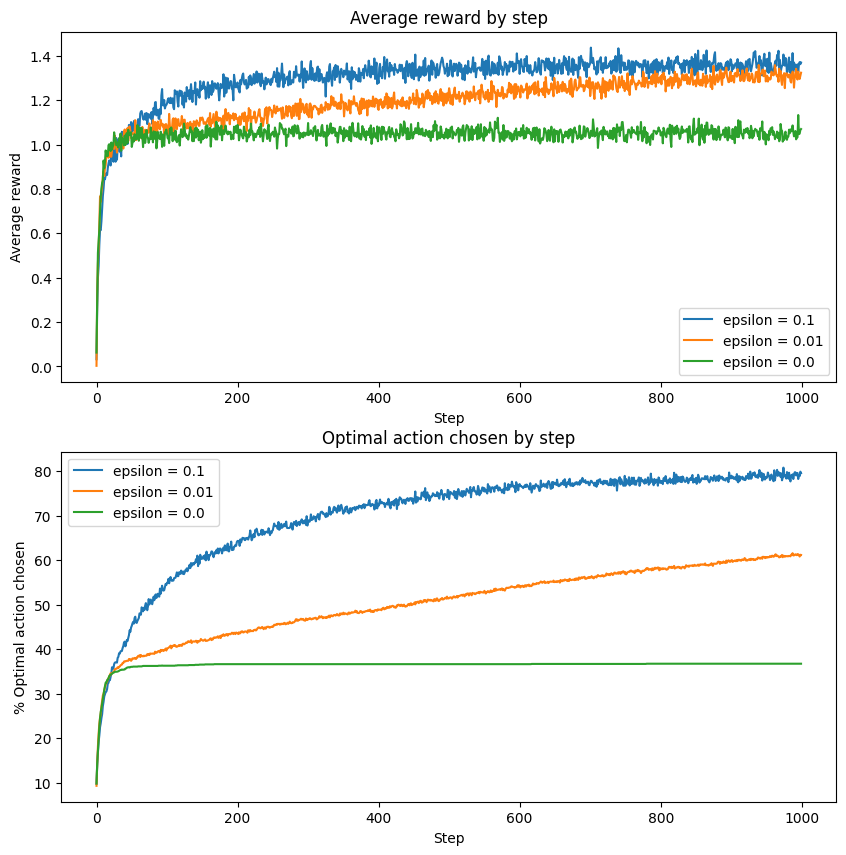

In [39]:
from matplotlib import pyplot as plt

fig, ax = plt.subplots(2, 1, figsize=(10, 10))

for i, agent_eps in enumerate(agents_epsilons):
    ax[0].plot(agents_avg_reward_by_step[i], label=f'epsilon = {agent_eps}')
    ax[1].plot(agent_optimal_action_chosen_by_step[i] * 100, label=f'epsilon = {agent_eps}')

ax[0].set_title('Average reward by step')
ax[0].set_xlabel('Step')
ax[0].set_ylabel('Average reward')
ax[0].legend()

ax[1].set_title('Optimal action chosen by step')
ax[1].set_xlabel('Step')
ax[1].set_ylabel('% Optimal action chosen')
ax[1].legend()

plt.show()

Notemos cómo para $\epsilon = 0.1$ la convergencia a la acción óptima es más rápida que para $\epsilon = 0.01$.

Sin embargo para $\epsilon = 0.01$ el agente terminará eligiendo la acción óptima más el 99% de las veces mientras que para $\epsilon = 0.1$ lo hará el 90% de las veces.

## Implementación incremental del cálculo de Q

La implementación de Q que hemos hecho hasta ahora es la más simple, sin embargo, podemos hacer una implementación incremental del cálculo de Q que nos permitirá hacer el cálculo de Q más eficiente.

La fórmula usada hasta ahora para el cálculo de Q es:

$$Q_{k+1}(a) = \frac{R_1 + R_2 + ... + R_{k}}{k}$$

Donde k es el número de veces que se ha elegido la acción a.

Podemos reescribir esta fórmula de la siguiente manera:

$$Q_{k+1}(a) = Q_k(a) + \frac{1}{k}[R_k - Q_k(a)]$$

In [40]:
agents_epsilons = [0.1, 0.01, 0.0]
steps = 1000
tasks_qty = 2000

agents_avg_reward_by_step, agent_optimal_action_chosen_by_step = experiment_figure_2_1(
    agents_epsilons,
    steps,
    tasks_qty,
    agent_class=armed_bandit.IncrementalAgent
)

Experiment took 3.50 minutes


El experimento pasó a tardar la mitad del tiempo que tardó con la implementación anterior.

In [ ]:
from matplotlib import pyplot as plt

fig, ax = plt.subplots(2, 1, figsize=(10, 10))

for i, agent_eps in enumerate(agents_epsilons):
    ax[0].plot(agents_avg_reward_by_step[i], label=f'epsilon = {agent_eps}')
    ax[1].plot(agent_optimal_action_chosen_by_step[i] * 100, label=f'epsilon = {agent_eps}')

ax[0].set_title('Average reward by step')
ax[0].set_xlabel('Step')
ax[0].set_ylabel('Average reward')
ax[0].legend()

ax[1].set_title('Optimal action chosen by step')
ax[1].set_xlabel('Step')
ax[1].set_ylabel('% Optimal action chosen')
ax[1].legend()

plt.show()

Esta última regla de actualización se engloba dentro de un conjunto de reglas que siguen la forma:

$$NewEstimante \leftarrow OldEstimate + StepSize~[Target - OldEstimate]$$

Donde la expresión $[Target - OldEstimate]$ es el error en la estimación y el término $StepSize$ es un hiperparámetro que controla la rapidez con la que se actualiza la estimación.